---
title: "Quality Control: initial steps"
author:
    - name: Conor O'Hare
    - name: Samuele Soraggi
      orcid: 0000-0002-1159-5535
      email: samuele@birc.au.dk
    - name: Alba Refoyo Martinez
      orcid: 0000-0002-3674-4007
      email: alba.martinez@sund.ku.dk     
---

---
format:
  html:
   theme: default
   number-sections: true
   code-fold: false
   self-contained: false
   toc: true
   highlight-style: pygments
  ipynb:
    toc: true
    number-sections: false
---

::: {.callout-note title="Important notes for this notebook" icon=false}

After gathering your data and genotyping, there are many checks one can do to determine the quality of the data. PLINK will generate a number of standard summary statistics that are useful for quality control (e.g. missing genotype rate, minor allele frequency, and Hardy-Weinberg equilibrium failures). These can also be used as thresholds for subsequent analyses, as will be shown in this section.

## Learning outcomes

- **distinguish** the various QC steps
- **discuss and choose** thresholds on plink
- **implement** basic QC in `plink` and statistical plots in `R`
- **hypothesize** the effects of various `plink` commands and **verify** your hypothesis using the analysis in `R`


## How to make this notebook work

* In this notebook we will use primarily `R` and `bash command line` programming languages, where `R` is used for statistical analysis of the output from various tools running in `bash`
* Since we use multiple coding languages, you need to choose a kernel every time we shift from one language to another. A kernel contains a programming language and the necessary packages to run the course material. To choose a kernel, go on the menu on the top of the page and select `Kernel --> Change Kernel`, and then select the preferred one.
* We will shift between two kernels, and along the code in this notebook you will see a picture telling you to change kernel. The two pictures are below:

<center>
<img src="Images/bash.png" alt="Bash" width="80"> Choose the Bash kernel
<img src="Images/R.png" alt="R" width="80"> Choose the R-GWAS kernel
</center>

* You can run the code in each cell by clicking on the run cell sign in the toolbar, or simply by pressing <kbd>Shift</kbd>+<kbd>Enter</kbd>. When the code is done running, a small green check sign will appear on the left side.
* You need to run the cells in sequential order to execute the analysis. Please do not run a cell until the one above is done running, and do not skip any cells
* The code goes along with textual descriptions to help you understand what happens. Please try not to focus on understanding the code itself in too much detail - but rather try to focus on the explanations and on the output of the commands 
*   You can create new code cells by pressing `+` in the Menu bar above or by pressing <kbd>B</kbd> after you select a cell. 

:::

The next step in any GWAS is to examine the data for potential problems. You don’t want to carry out a GWAS, think you have an exciting result, then discover that it was all just an artifact of bad data. 

After gathering your data and genotyping, there are many checks one can do to determine the quality of the data. PLINK will generate a number of standard summary statistics that are useful for quality control (e.g. missing genotype rate, minor allele frequency, and Hardy-Weinberg equilibrium failures). These can also be used as thresholds for subsequent analyses, as will be shown in this section.

For this tutorial, we will look at the following topics: 

1) Individual Missingness  
2) Sex discrepency  
3) Minor Allele Frequency (MAF)  
4) Hardy-Weinburg Equilibrium (HWE)  
5) Heterozygosity Rate  

In the next section, which is a continuation of quality control, we will look at:

6) Relatedness  
7) Population Stratification/Structure  

# Individual and SNP Missingness


## Missingness per SNP

Overall, the SNP genotyping platform is very reliable and delivers stable results when it comes to determining genotypes. Of course, it is not flawless. One of the most frequent problems is that some of the SNPs are just not well genotyped in the entire population. These should be removed to improve the overall data quality.

Of course, we cannot remove every SNP that has any missing value, as this way we would purge the entirety of our data. As a comproimse, we define thresholds instead. The thing about these thresholds is that no rule would firmly set which ones to use. So you are free to define them as long as you remain within "reasonable" bounds. To find out what "reasonable" means, it is perhaps a good idea to study the literature for your species of interest. For humans, we typically begin with a threshold of 0.2. That is, we remove SNPs where  20% or more of that SNP are not genotyped in our population.

## Missingness per individual

The reliability of SNP chips is also high when it comes to individual genotypes. In some cases, however, some of the individuals contain a large number of missing SNPs. The reason could be low DNA sample quality, wrong chip type used (e.g. cattle chip for deer samples), or other technical issues. Regardless of the reason, you should delete the worst offenders from your data set, not to compromise the overall quality of your results.


## Example

Have a look at the following toy example:

|   /   | SNP1 | SNP2 | SNP3 | SNP4 | SNP5 |
|------|------|------|------|------|------|
| IND1 | 22   | 00   | 11   | 12   | 22   |
| IND2 | 22   | 00   | 11   | 12   | 22   |
| IND3 | 11   | 12   | 11   | 22   | 21   |
| IND4 | 00   | 00   | 11   | 11   | 22   |
| IND5 | 22   | 00   | 11   | 22   | 22   |

We have a data set of five individuals, each of them genotyped for five SNPs. The genotypes themselves are in numerical coding, 11 and 22 being the two homozygous, 12 the heterozygous, and 00 coded as missing.

Let's say we want to remove SNPs with >= 40% missingness. In this example, only SNP2 exceeds this threshold, with 80% missingness. So it is removed from the data set. 

Now we apply the >= 40% missingess theshold to the individuals, which removes IND4 from the data set, as there is missing genotype information for 2/5 = 40% SNPs. 

In practice, you want to remove the SNPs based on missingess before the individuals. This is simply because we generally have a lot more SNPs than individuals, and would thus lose less information by removing SNPs than individuals, which can be achieved by removing the "bad" SNPs first, leaving a lower rate of missingess for all the individuals.

## Commands

We can deal with missingness in PLINK with two functions: 

* `--geno`: This will remove SNPs with a specified proportion of missingness (e.g. `--geno 0.01` will remove SNPs with 1% missingness.
* `--mind`: This will remove individuals with a specified proportion of missingness (e.g. `--mind 0.01` will remove individuals with 1% missingness.

We now implement our first QC method in PLINK:

<img src="Images/bash.png" alt="Bash" width="40"> We link the data folder to easily access it and create a folder for files in output from the used commands

In [1]:
ln -sf ../Data
mkdir -p Results/GWAS3

and run plink

In [2]:
### Step 1 - Missingness ###

# Investigate missingness per individual and per SNP and make histograms.
# Note: the '> /dev/null' command is to suppress output. We do this for purely aesthetic reasons, but you can 
# remove it to read more about what PLINK is doing 
plink --bfile Data/HapMap_3_r3_1 --missing --out Results/GWAS3/data

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/data.log.
Options in effect:
  --bfile Data/HapMap_3_r3_1
  --missing
  --out Results/GWAS3/data

385572 MB RAM detected; reserving 192786 MB for main workspace.
1457897 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
commands treat these as missing.
Total genotyping rate is 0.997378.
--missing: Sample missing data report written to Results/GWAS3/data.imiss, and
variant-based missing data repo

Immediately we can see that our total genotyping rate for our sample is 0.997378. Furthermore, there will be two output files from this command: `plink.imiss` and `plink.lmiss`, in the directory `Results/GWAS3/`. These files show respectively the proportion of missing SNPs per individual and the proportion of missing individuals per SNP. 

<img src="Images/R.png" alt="R" width="40"> We can visualise the missingness in individuals and SNPs using histograms in `R`:

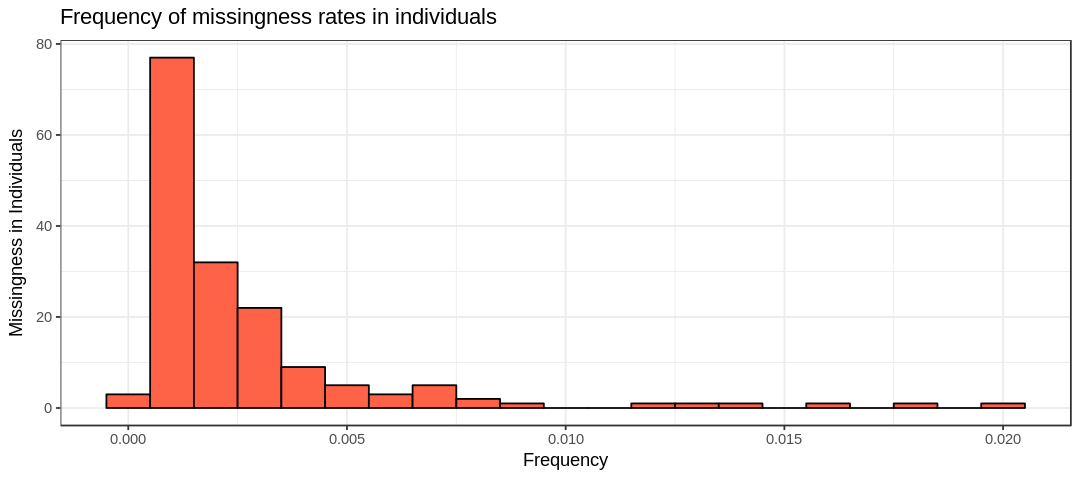

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


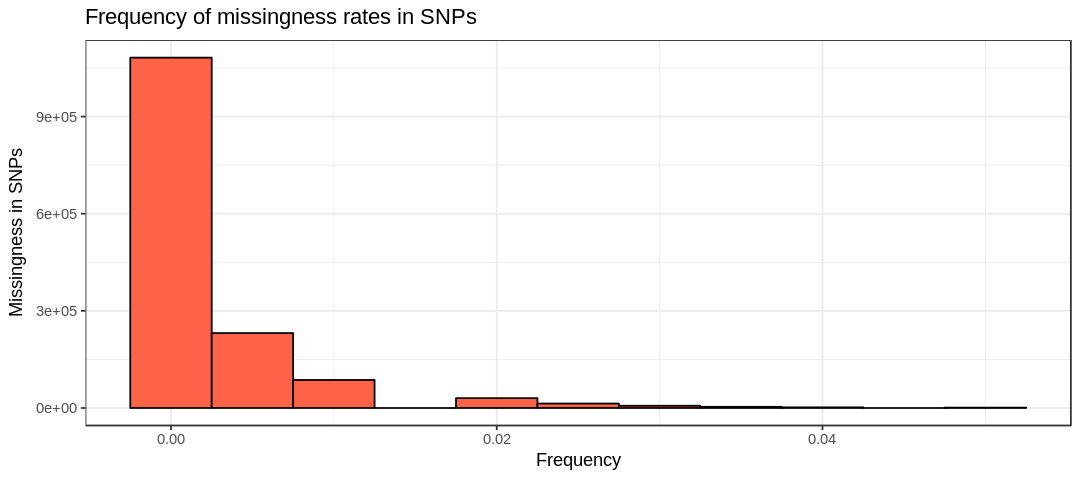

In [1]:
library(ggplot2)
options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
indmiss <- read.table(file="Results/GWAS3/data.imiss", header=TRUE)
snpmiss <- read.table(file="Results/GWAS3/data.lmiss", header=TRUE)

# plink.imiss histogram
hist.imiss <- ggplot(indmiss, aes(x=indmiss[,6])) +
  geom_histogram(binwidth = 0.001, col = "black", fill="tomato") + 
  labs(title = "Frequency of missingness rates in individuals") + 
  xlab("Frequency") + 
  ylab("Missingness in Individuals") + 
  theme_bw()

# plink.lmiss histogram
hist.lmiss <- ggplot(snpmiss, aes(x=snpmiss[,5])) +
  geom_histogram(binwidth = 0.005, col = "black", fill="tomato") + 
  labs(title = "Frequency of missingness rates in SNPs") + 
  xlab("Frequency") + 
  ylab("Missingness in SNPs") + 
  theme_bw()

show(hist.imiss)
show(hist.lmiss)

# Save plots 
ggsave(plot=hist.imiss, filename="Results/GWAS3/histimiss.png")
ggsave(plot=hist.lmiss, filename="Results/GWAS3/histlmiss.png")

Histograms are also saved in your results directory as `histimiss.png`and `histlmiss.png`. We can make a few observations. First, note that there are very few individuals with no missingness at all. This is likely given that there only needs to be one SNP that is genotyped badly across all samples. Fortunately, this is not the case, and as we can see in the second histogram, the largest missingness percentage for a SNP is around 0.05 (that is, 5%). All in all, the histogram can offer some indication as to how much a certain missingness filter will impact the size of your remaining data. 

<img src="Images/bash.png" alt="Bash" width="40">  We will now use PLINK along with our missingness filters to QC the data. We outline the command below removing samples with more than 20% missingness (option `--mind`) and SNPs with more than 2% missingness (option `--geno`). The `--out` option defines a prefix for the output file, and `--make-bed` denotes an output in `.bed` format. PLINK is very verbose, so look at the text it prints out when running the command to see what it is doing.

***

In [5]:
# Delete SNPs and individuals with high levels of missingness

# The following two QC commands will not remove any SNPs or individuals. However, it is good practice 
# to start the QC with these non-stringent thresholds.  

# Delete SNPs with missingness >0.2.
#plink --bfile Data/HapMap_3_r3_1 --geno 0.2 --make-bed --out Results/GWAS3/HapMap_3_r3_2 > /dev/null

# Delete individuals with missingness >0.2.
#plink --bfile Results/GWAS3/HapMap_3_r3_2 --mind 0.2 --make-bed --out Results/GWAS3/HapMap_3_r3_3 > /dev/null

# Delete SNPs with missingness >0.02.
#plink --bfile Results/GWAS3/HapMap_3_r3_3 --geno 0.02 --make-bed --out Results/GWAS3/HapMap_3_r3_4 > /dev/null

# Delete individuals with missingness >0.02.
#plink --bfile Results/GWAS3/HapMap_3_r3_4 --mind 0.02 --make-bed --out Results/GWAS3/HapMap_3_r3_5 > /dev/null

In [2]:
# Delete SNPs and individuals with high levels of missingness

# The following two QC commands will not remove any SNPs or individuals. However, it is good practice 
# to start the QC with these non-stringent thresholds.  

# Delete samples with missing call freq >0.2 and SNPs with missingness >0.02
plink --bfile Data/HapMap_3_r3_1 --mind .2 --geno .02 --make-bed --out Results/GWAS3/HapMap_3_r3_2

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/HapMap_3_r3_2.log.
Options in effect:
  --bfile Data/HapMap_3_r3_1
  --geno .02
  --make-bed
  --mind .2
  --out Results/GWAS3/HapMap_3_r3_2

385572 MB RAM detected; reserving 192786 MB for main workspace.
1457897 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
0 people removed due to missing genotype data (--mind).
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
); many commands treat these as missing.
Total genotyping rate is 0.997378.
27

***

# Sex Discrepancy

One check that is worth running is a check if the indicated genders are correct. You can check this using PLINK to calculate the inbreeding coefficient on the X chromosome under the assumption that it is an autosomal chromosome. The reason why this is interesting is that, for technical reasons PLINK represents haploid chromosomes, such as X for males, as homozygotes. So assuming the X is an autosomal chromosome will make the males look very inbred on the X where as the woman won't (since they are diploid on the X chromosome). This means that the inbreeding coefficient estimates you get will be close to 1 for men and close to 0 for women.

## Commands

This gender check can be performed in PLINK using the `--check-sex` option. The results are outputted in the file `plink.sexcheck` (in the results folder) in which the gender is in column `PEDSEX` (1 means male and 2 means female) and the inbreeding coefficient is in column `F`).

Generally, Males should have an X chromosome homozygosity estimate >0.8 and females should have a value <0.2. So we could simply remove any individuals where homozygosity estimate (F) does not match their specified sex.

In [4]:
### Step 2 - Sex Discrepency ####

# Subjects who were a priori determined as females must have a F value of <0.2, 
# and subjects who were a priori determined as males must have a F value >0.8. 
# This F value is based on the X chromosome inbreeding (homozygosity) estimate.
# Subjects who do not fulfil these requirements are flagged "PROBLEM" by PLINK.

plink --bfile Results/GWAS3/HapMap_3_r3_2 --check-sex --out Results/GWAS3/HapMap_3_r3_2

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/HapMap_3_r3_2.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_2
  --check-sex
  --out Results/GWAS3/HapMap_3_r3_2

385572 MB RAM detected; reserving 192786 MB for main workspace.
1430443 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
); many commands treat these as missing.
Total genotyping rate is 0.997899.
1430443 variants and 165 people pass filters and QC.
Among remaining phen

<img src="Images/R.png" alt="R" width="40">   We can visualise the results of the sex check by plotting three histograms for the F values in males, females and all samples:

In [6]:
# Generate plots to visualize the sex-check results.
#Rscript --no-save Data/gender_check.R > /dev/null

Warning message:
package ‘ggplot2’ was built under R version 4.1.3 
Saving 7 x 7 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Saving 7 x 7 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Saving 7 x 7 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


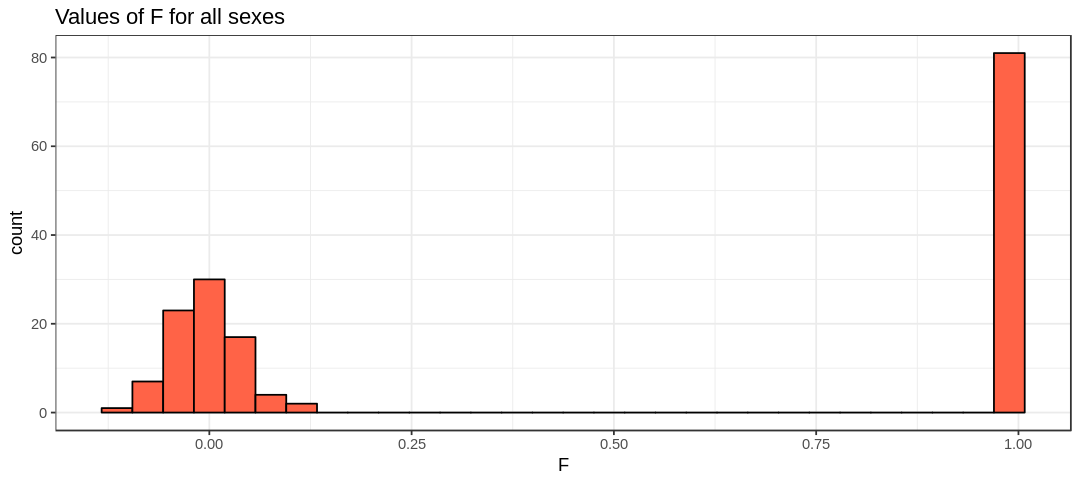

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


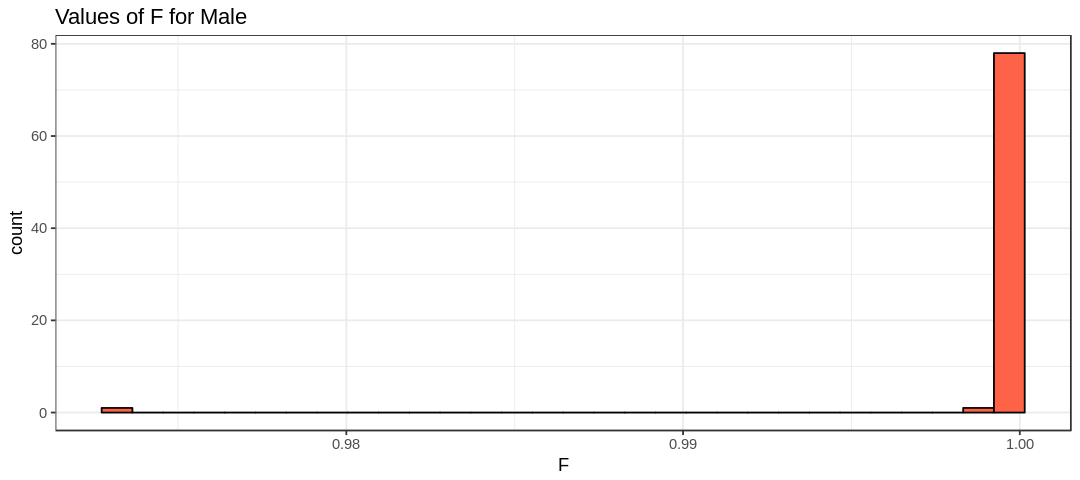

Saving 6.67 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Saving 6.67 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Saving 6.67 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


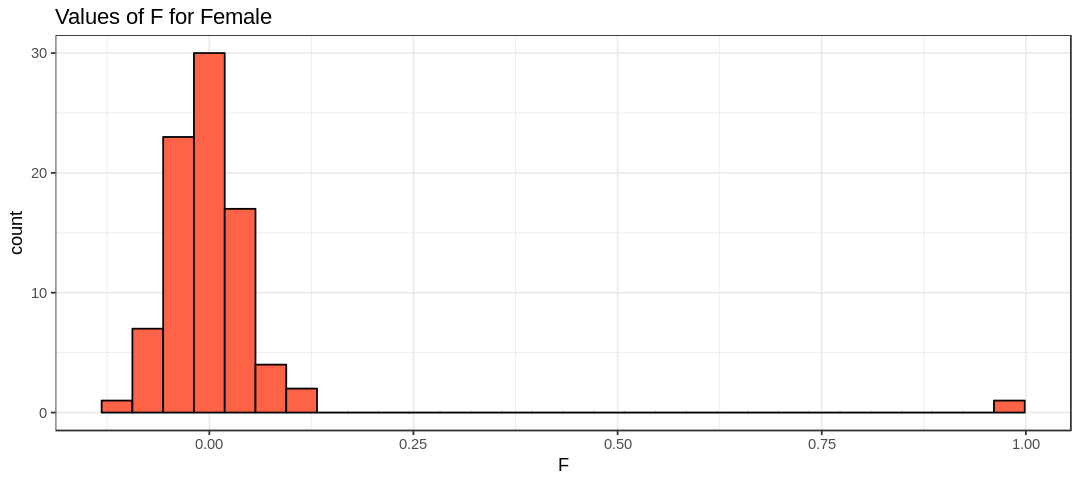

In [5]:
#| label: fig-F
#| fig-cap: "inbreeding coefficients for all genders and for males/females separately."

library(ggplot2)
options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R
gender <- read.table("Results/GWAS3/HapMap_3_r3_2.sexcheck", header=T,as.is=T)
male <- subset(gender, gender$PEDSEX==1)
female <- subset(gender, gender$PEDSEX==2)

# plink.imiss histogram
hist.gender <- ggplot(gender, aes(x=gender[,6])) +
  geom_histogram(col = "black", fill="tomato") + 
  labs(title = "Values of F for all sexes") + 
  xlab("F") + 
  theme_bw()

# plink.imiss histogram
hist.male <- ggplot(male, aes(x=male[,6])) +
  geom_histogram(col = "black", fill="tomato") + 
  labs(title = "Values of F for Male") + 
  xlab("F") + 
  theme_bw()


# plink.imiss histogram
hist.female <- ggplot(female, aes(x=female[,6])) +
  geom_histogram(col = "black", fill="tomato") + 
  labs(title = "Values of F for Female") + 
  xlab("F") + 
  theme_bw()

show(hist.gender)
show(hist.male)
show(hist.female)

# Save plots 
ggsave(plot=hist.gender, filename="Results/GWAS3/histgender.png")
ggsave(plot=hist.male, filename="Results/GWAS3/histmale.png")
ggsave(plot=hist.female, filename="Results/GWAS3/histfemale.png")

The inbreeding coefficient plot of @fig-F indicates that there is one woman with a sex discrepancy, with an F value of 0.99. When using other datasets often a few discrepancies will be found. 

We have two options when dealing with sex discrepency. One is to simply remove any individual with sex discrepency. In our case, this would involve removing the female with an F value of 0.99. 

<img src="Images/bash.png" alt="bash" width="40">   Removal can be done with the command below. We use `grep` to find the lines containin `PROBLEM` in the sexcheck file. The output is sent to another command (using the so-called pipe symbol `|`) called `awk`. `awk` prints out the first two columns of each line from `grep` into the file `sex_discrepancy.txt` through the symbol `>`, which redirects the output somewhere else than the screen itself.

In [2]:
# 1) Delete individuals with sex discrepancy.

# Generate a list of individuals with the status PROBLEM
grep "PROBLEM" Results/GWAS3/HapMap_3_r3_2.sexcheck | awk '{print$1,$2}'> Results/GWAS3/sex_discrepancy.txt

Using `cat` you can show the file, where you see only one individual.

In [4]:
cat Results/GWAS3/sex_discrepancy.txt

1349 NA10854


For long files, you can simply count the number of lines in the file with `wc`

In [6]:
# Read the list of individuals with the status PROBLEM
wc -l Results/GWAS3/sex_discrepancy.txt

1 Results/GWAS3/sex_discrepancy.txt


The file can be provided to PLINK for removal using the option `--remove`:

In [7]:
# Remove the list of individuals with the status PROBLEM.
plink --bfile Results/GWAS3/HapMap_3_r3_2 --remove Results/GWAS3/sex_discrepancy.txt --make-bed --out Results/GWAS3/HapMap_3_r3_3

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/HapMap_3_r3_3.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_2
  --make-bed
  --out Results/GWAS3/HapMap_3_r3_3
  --remove Results/GWAS3/sex_discrepancy.txt

385572 MB RAM detected; reserving 192786 MB for main workspace.
1430443 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
--remove: 164 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
); many commands treat these as missing.
Total genotyping rate in remaini

Another method is to impute the sex codes based on the SNP data, which is done with the command `--impute-sex`. We are not executing the command below and will keep only the dataset where we filtered out the wrong gender. PLINK finds out automatically how to impute wrong genders, so you need just to type the extra option into it.

In [8]:
#plink --bfile Results/GWAS3/HapMap_3_r3_2 --impute-sex --make-bed --out Results/GWAS3/HapMap_3_r3_3

# Minor Allele Frequency (MAF)

Excluding SNPs on the basis of minor allele frequency is somewhat controversial. In a sense, it has little to do with quality control – there is no reason to think there are any errors in the data. The main justification is statistical:

If MAF is low, power is low (i.e. don’t spend multiple testing corrections on tests that are unlikely to find anything anyway). Some statistical methods perform badly with low MAF (e.g. the chi-squared-test).

An appropriate cutoff definitely depends on sample size – the larger the sample, the greater your ability to include rare SNPs.

## Command

Limitations on the minor allele frequencies are done in a similar way to previous commands. If you want to get rid only of the fixed SNPs, you specify a MAF threshold of 0, which can be done by the command `--maf 0`. One should limit MAF analysis to autosomal chromosomes only.

First, we generate a subset of our data to only contain autosomal chromosomes. This is done by printing the SNP identifiers out of chromosomes 1 to 22 with `awk`, whose output is sent to file `snp_1_22.txt`. Then, PLINK can extract those SNPs using the option `--extract`.

In [11]:
awk '{ if ($1 >= 1 && $1 <= 22) print $2 }' Results/GWAS3/HapMap_3_r3_3.bim > Results/GWAS3/snp_1_22.txt
plink --bfile Results/GWAS3/HapMap_3_r3_3 --extract Results/GWAS3/snp_1_22.txt --make-bed --out Results/GWAS3/HapMap_3_r3_4

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/HapMap_3_r3_4.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_3
  --extract Results/GWAS3/snp_1_22.txt
  --make-bed
  --out Results/GWAS3/HapMap_3_r3_4

385572 MB RAM detected; reserving 192786 MB for main workspace.
1430443 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
--extract: 1398544 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998052.
1398544 variants and 164 people pass 

Now that we have a set of files with autosomal chromosomes only, we should have a look at the summary statistics for the minor allele frequency, and plot the values on a histogram. We use PLINK to print out the MAF with the option `--freq`.

In [12]:
# Generate a plot of the MAF distribution.
plink --bfile Results/GWAS3/HapMap_3_r3_4 --freq --out Results/GWAS3/MAF_check

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/MAF_check.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_4
  --freq
  --out Results/GWAS3/MAF_check

385572 MB RAM detected; reserving 192786 MB for main workspace.
1398544 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998052.
--freq: Allele frequencies (founders only) written to
Results/GWAS3/MAF_check.frq .


<img src="Images/R.png" alt="R" width="40"> And we plot with `R` the MAF histogram. We zoom also into the histogram to observe the lowest side of the horizontal axis.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 929441 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1 rows containing missing values (geom_bar).”

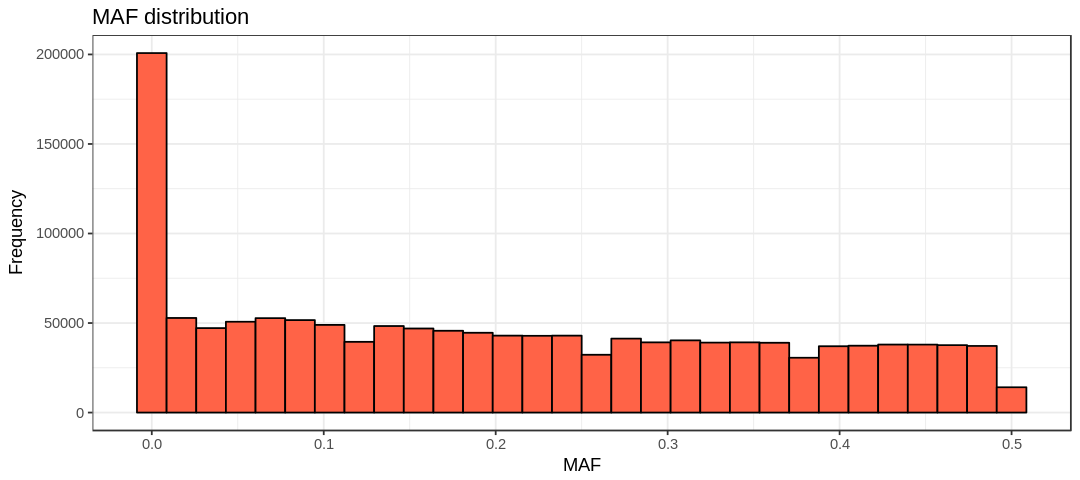

Saving 6.67 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


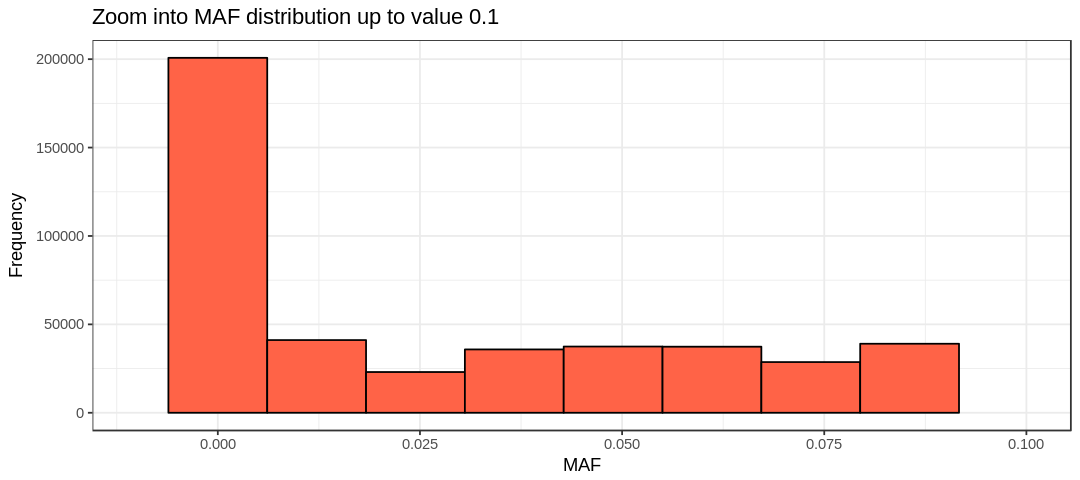

In [1]:
#| label: fig-MAF
#| fig-cap: "MAF plot for the autosomal SNPs only. Note the zoomed interval (0, 0.1)"

library(ggplot2)
options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
maf_freq <- read.table("Results/GWAS3/MAF_check.frq", header =TRUE, as.is=T)

# maf_freq histogram
hist.maf <- ggplot(maf_freq, aes(x=maf_freq[,5])) +
  geom_histogram(col = "black", fill="tomato") + 
  labs(title = "MAF distribution") + 
  xlab("MAF") + 
  ylab("Frequency") +
  theme_bw()

hist.maf.zoom <- ggplot(maf_freq, aes(x=maf_freq[,5])) +
  geom_histogram(col = "black", fill="tomato", bins = 10) + 
  labs(title = "Zoom into MAF distribution up to value 0.1") + 
  xlab("MAF") + 
  ylab("Frequency") +
  xlim(-.01, 0.1) +
  theme_bw()


show(hist.maf)
show(hist.maf.zoom)

# Save plots 
ggsave(plot=hist.maf, filename="Results/GWAS3/histmaf.png")

<img src="Images/bash.png" alt="bash" width="40"> As stated above, your MAF threshold depends on sample size, though a conventional MAF threshold for a regular GWAS is between 0.01 or 0.05. Here it could make sense to chose 0.02, but to be sure we include only SNPs will apply an MAF threshold of 0.05 (that is, remove SNPs where the Minor Allele Frequency is 5% or less). The threshold is given with the option `--maf`:

In [1]:
# Remove SNPs with a low MAF frequency.
plink --bfile Results/GWAS3/HapMap_3_r3_4 --maf 0.05 --make-bed --out Results/GWAS3/HapMap_3_r3_5

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/HapMap_3_r3_5.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_4
  --maf 0.05
  --make-bed
  --out Results/GWAS3/HapMap_3_r3_5

385572 MB RAM detected; reserving 192786 MB for main workspace.
1398544 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998052.
325318 variants removed due to minor allele threshold(s)
(--maf/--max-maf/--mac/--max-mac).
1073226 va

We can see from the output that 1073226 SNPs are left in our QC'd dataset. 

It is worth noting that no matter what the sample size, monomorphic SNPs (i.e., SNPs that show no genetic variation whatsoever in the sample) are usually problematic and should always be removed. Some code crashes when monomorphic SNPs are included; even if this weren’t the case, these SNPs cannot possibly be informative in a genome-wide association study.

# Hardy-Weinberg Equilibrium (HWE)

The Hardy-Weinberg rule from population genetics states that genetic variation (thus allele and genotype frequencies) in a population will remain constant unless certain disturbing elements are introduced. This also means that when we know the allele frequencies for $p$ and $q$, the genotype frequencies will be defined as $p^2$, $2pq$, and $q^2$.

Let's say the frequency of allele A ($p$ in the equation)is 0.4, and that of allele B (q in the equation) is 0.6. This means for the H-W scenario the genotype frequencies will be 0.16 for AA, 0.48 for AB, and 0.36 for BB. This also means that in a population of e.g. 1000 individuals with the mentioned allele frequencies we expect to see 160 AA, 480 AB, and 360 BB individuals. Of course, we rarely see exact H-W distributions in real populations. The question then becomes, what is the extent of the difference between the expected H-W proportions in each SNP, and the observed proportions in the reality? There are typically two reasons why a SNP is not in HWE:

* There was a genotyping error for this SNP
* Mating is not random

In the real world, mating is of course not random, making it difficult to exclude SNPs on the basis of HWE. The usual recommendation is to exclude a SNP only if HWE is hugely violated (e.g., p-value p<10−10 for a statistical test of whether the data follow a binomial distribution).

## Command

We can use the option `--hardy` to generate H-W p-values (as well as observed and expected heterozygosity). We use also `awk` to select SNPs with HWE p-value below 0.0001, which are strongly deviating from H-W equilibrium.

In [1]:
plink --bfile Results/GWAS3/HapMap_3_r3_5 --hardy --out Results/GWAS3/HapMap_3_r3_5

awk '{ if ($9 <0.00001) print $0 }' Results/GWAS3/HapMap_3_r3_5.hwe > Results/GWAS3/HapMap_3_r3_5.deviating.hwe

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/HapMap_3_r3_5.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_5
  --hardy
  --out Results/GWAS3/HapMap_3_r3_5

385572 MB RAM detected; reserving 192786 MB for main workspace.
1073226 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998039.
--hardy: Writing Hardy-Weinberg report (founders only) to
Results/GWAS3/HapMap_3_r3_5.hwe ... 101112131415161718192021

<img src="Images/R.png" alt="R" width="40"> Now we plot a histogram of the HWE p-values and zoom in for the deviating p-values. We first read in the data and look at the table from the HWE test in PLINK. When you use the `--hardy` option in PLINK, the columns in the output file typically include the following:

- CHR: Chromosome number.
- SNP: SNP identifier (rsID).
- TEST: Type of HWE test performed. This will usually be "UNAFF" for the test on controls if your data has case/control status.
- A1: First allele (reference allele).
- A2: Second allele (alternate allele).
- GENO: Genotype counts in the format "HOM1/HET/HOM2", where HOM1 is the count of homozygous for the first allele, HET is the count of heterozygous, and HOM2 is the - count of homozygous for the second allele.
- O(HET): Observed heterozygote frequency.
- E(HET): Expected heterozygote frequency.
- P: Hardy-Weinberg equilibrium exact test p-value.
  
we change the factors in the column `TEST` to have nicer names in the plots, and save them in the column Phenotype.

In [3]:
# Read data into R 
library(dplyr)

hwe <- read.table(file="Results/GWAS3/HapMap_3_r3_5.hwe", header=TRUE)
hwe_zoom <- read.table(file="Results/GWAS3/HapMap_3_r3_5.deviating.hwe", header=FALSE)
colnames(hwe_zoom) <- colnames(hwe)
hwe$Phenotype <- recode(hwe$TEST, "ALL"="All", "UNAFF"="Control", "AFF"="Non-Control")
hwe_zoom$Phenotype <- recode(hwe_zoom$TEST, "ALL"="All", "UNAFF"="Control", "AFF"="Non-Control")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Here you can see the first rows of the two tables

In [4]:
#| label: fig-HWEtables
#| fig-cap: "HWE tables from PLINK"

head(hwe)
head(hwe_zoom)

CHR,SNP,TEST,A1,A2,GENO,O.HET.,E.HET.,P,Phenotype
1,rs3131972,ALL,A,G,2/33/77,0.2946,0.2758,0.7324,All
1,rs3131972,AFF,A,G,1/19/36,0.3393,0.3047,0.6670,Non-Control
1,rs3131972,UNAFF,A,G,1/14/41,0.2500,0.2449,1.0000,Control
1,rs3131969,ALL,A,G,2/26/84,0.2321,0.2320,1.0000,All
1,rs3131969,AFF,A,G,1/17/38,0.3036,0.2817,1.0000,Non-Control
1,rs3131969,UNAFF,A,G,1/9/46,0.1607,0.1771,0.4189,Control


CHR,SNP,TEST,A1,A2,GENO,O.HET.,E.HET.,P,Phenotype
3,rs7623291,ALL,T,C,22/28/62,0.2500,0.4362,8.938e-06,All
7,rs34238522,ALL,C,T,0/64/48,0.5714,0.4082,3.515e-06,All
8,rs3102841,ALL,C,A,8/78/23,0.7156,0.4905,1.899e-06,All
9,rs354831,ALL,C,T,12/18/82,0.1607,0.3047,6.339e-06,All
9,rs10990625,ALL,C,T,23/28/61,0.2500,0.4424,9.391e-06,All
9,rs10990625,AFF,C,T,15/8/33,0.1429,0.4483,3.574e-07,Non-Control


Now we plot the histograms. We isolate each phenotype to see if there are any significant differences in p-value distribution between them.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


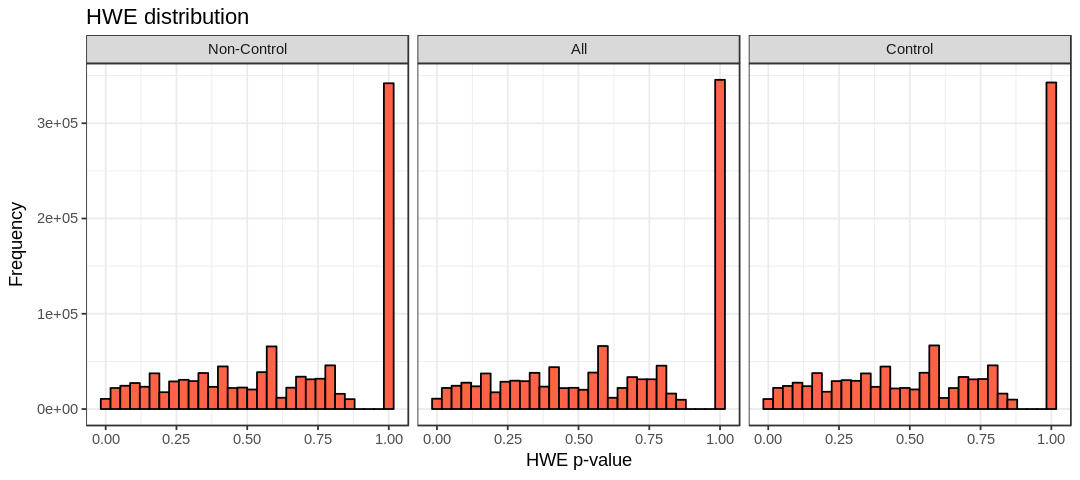

Saving 6.67 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Saving 6.67 x 6.67 in image


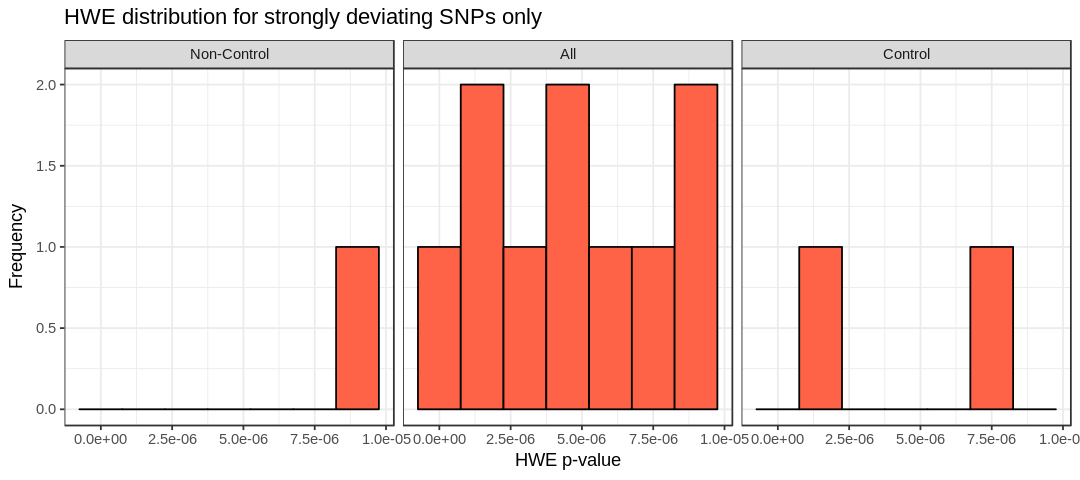

In [5]:
#| label: fig-HWE
#| fig-cap: "HWE p-values calculated with PLINK and zoom for the SNPs deviating from HWE. We can spot some deviations from HWE in the zoomed plot. Note that the p+values for the phenotype `All` is not the merging of the barplots from the other two phenotypes!"

library(ggplot2)
options(repr.plot.width = 9, repr.plot.height = 4)

# maf_freq histogram
hist.hwe <- ggplot(hwe, aes(x=hwe[,9])) +
  geom_histogram(col = "black", fill="tomato") + 
  labs(title = "HWE distribution") + 
  xlab("HWE p-value") + 
  ylab("Frequency") +
  facet_wrap(~Phenotype) +
  theme_bw()

# maf_freq histogram
hist.hwe_below_threshold <- ggplot(hwe_zoom, aes(x=hwe_zoom[,9])) +
  geom_histogram(binwidth = 0.0000015, col = "black", fill="tomato") + 
  labs(title = "HWE distribution for strongly deviating SNPs only") + 
  xlab("HWE p-value") + 
  ylab("Frequency") +
  facet_wrap(~Phenotype) +
  theme_bw()

show(hist.hwe)
show(hist.hwe_below_threshold)

# Save plots 
ggsave(plot=hist.hwe, filename="Results/GWAS3/histhwe.png")
ggsave(plot=hist.hwe_below_threshold, filename="Results/GWAS3/histhwe_below_threshold.png")

<img src="Images/bash.png" alt="bash" width="40">  Almost all of our SNPs are in HWE, as determined by their test to see if the alleles follow a binomial distribution. However, we can spot a few extreme deviations in our zoomed plot. We can remove these with the given threshold in PLINK, using the option `--hwe`.  Note that `--hwe` filters only on controls, so remember to add `include-nonctrl` to the command if you want to apply the threshold as well on non-control. In the two steps below we filter only controls with threshold `1e-6` and then all phenotypes with threshold `1e-10`

In [2]:
plink --bfile Results/GWAS3/HapMap_3_r3_5 --hwe 1e-6 --make-bed --out Results/GWAS3/HapMap_3_r3_5_onlycontrols

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/HapMap_3_r3_5_onlycontrols.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_5
  --hwe 1e-6
  --make-bed
  --out Results/GWAS3/HapMap_3_r3_5_onlycontrols

385572 MB RAM detected; reserving 192786 MB for main workspace.
1073226 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998039.
--hwe: 0 variants removed due to Hardy-Weinberg exact test.
1073226 variants

In [3]:
plink --bfile Results/GWAS3/HapMap_3_r3_5_onlycontrols --hwe 1e-10 include-nonctrl --make-bed --out Results/GWAS3/HapMap_3_r3_6

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/HapMap_3_r3_6.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_5_onlycontrols
  --hwe 1e-10 include-nonctrl
  --make-bed
  --out Results/GWAS3/HapMap_3_r3_6

385572 MB RAM detected; reserving 192786 MB for main workspace.
1073226 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998039.
--hwe: 0 variants removed due to Hardy-Weinberg exact test.
1073226 vari

# Heterozygosity Rate

A somewhat similar idea to HWE, but applied to individuals instead of SNPs (if an individual had a ton of A/B calls but no A/A or B/B calls, or vice versa, that would indicate something was wrong):

## Command

PLINK has no summary statistic for heterozygosity of individuals. Instead, we will first prune the dataset, checking heterozygosity on a set of SNPs which are not highly correlated. We do this because highly correlated regions reduce the power of our analysis. to generate a list of non-(highly)correlated SNPs, we exclude (`--exclude`) high inversion regions (already saved in `Data/inversion.txt`) and prune the SNPs using the option `--indep-pairwise`. The parameters `50 5 0.2` stand respectively for: the window size, the number of SNPs to shift the window at each step, and the multiple correlation coefficient for a SNP being regressed on all other SNPs simultaneously.

In [3]:
plink --bfile Results/GWAS3/HapMap_3_r3_6 --exclude Data/inversion.txt --range --indep-pairwise 50 5 0.2 --out Results/GWAS3/indepSNP

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/indepSNP.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_6
  --exclude Data/inversion.txt
  --indep-pairwise 50 5 0.2
  --out Results/GWAS3/indepSNP
  --range

Note: --range flag deprecated.  Use e.g. "--extract range <filename>".
385572 MB RAM detected; reserving 192786 MB for main workspace.
1073226 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
--exclude range: 9893 variants excluded.
--exclude range: 1063333 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757

With this pruned list, we measure the heterozygosity rates of the individuals in the remaining independent SNPs.

In [4]:
plink --bfile Results/GWAS3/HapMap_3_r3_6 --extract Results/GWAS3/indepSNP.prune.in --het --out Results/GWAS3/R_check

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/R_check.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_6
  --extract Results/GWAS3/indepSNP.prune.in
  --het
  --out Results/GWAS3/R_check

385572 MB RAM detected; reserving 192786 MB for main workspace.
1073226 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
--extract: 104144 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998028.
104144 variants and 164 people pass filters and QC

<img src="Images/R.png" alt="R" width="40"> Here we plot the distribution of heterozygosity rates. We first have a look at the heterozigosity table. When you use the `--het` option in PLINK, the output table has the columns:

- FID: Family ID of the individual.
- IID: Individual ID within the family.
- O(HOM): Observed number of homozygous genotypes.
- E(HOM): Expected number of homozygous genotypes under Hardy-Weinberg equilibrium.
- N(NM): Number of non-missing autosomal genotypes.
- F: Inbreeding coefficient (F), which is calculated as 
$$\tfrac{(E(HOM)−O(HOM))}{N(NM)}.

In [3]:
het <- read.table("Results/GWAS3/R_check.het", head=TRUE)
head(het)

FID,IID,O.HOM.,E.HOM.,N.NM.,F
1328,NA06989,67039,67470,103911,-0.0117200
1377,NA11891,66847,66840,102970,0.0001494
1349,NA11843,67262,67560,104071,-0.0082900
1330,NA12341,66654,67400,103826,-0.0205100
1444,NA12739,66687,66560,102519,0.0036020
1344,NA10850,67421,67520,104001,-0.0027780


We calculate by hand the heterozigosity rates so we can plot them (they are not inthe table by default). The formula for the rates is 
$$\tfrac{N(NM)-O(HOM)}{N(NM)}

Saving 6.67 x 6.67 in image


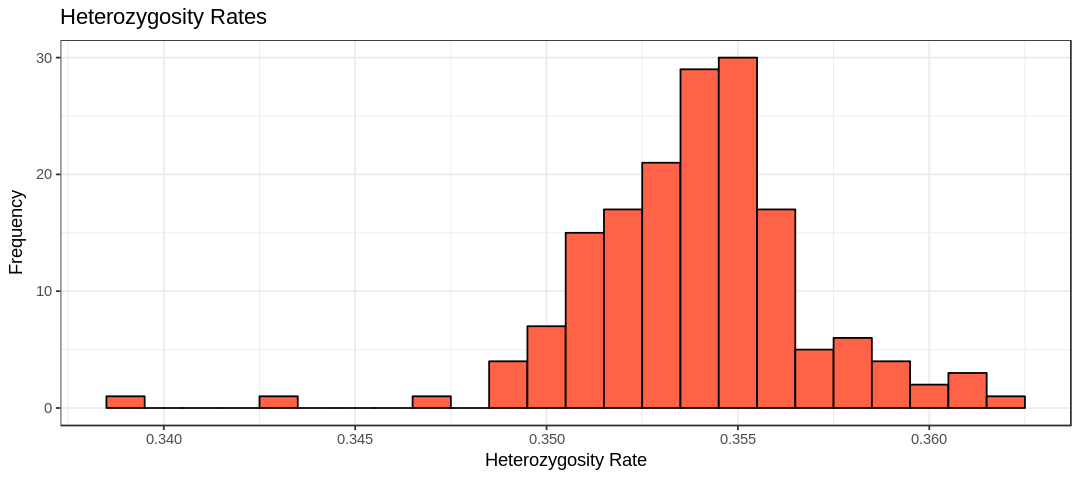

In [2]:
#| label: fig-HET
#| fig-cap: "Barplot of heterozigosity rates."

library(ggplot2)
options(repr.plot.width = 9, repr.plot.height = 4)

het$HET_RATE = (het$"N.NM." - het$"O.HOM.")/het$"N.NM."

# plink.imiss histogram
hist.het <- ggplot(het, aes(x=HET_RATE)) +
  geom_histogram(binwidth = 0.001, col = "black", fill="tomato") + 
  labs(title = "Heterozygosity Rates") + 
  xlab("Heterozygosity Rate") + 
  ylab("Frequency") + 
  theme_bw()


show(hist.het)

# Save plots 
ggsave(plot=hist.het, filename="Results/GWAS3/heterozygosity.png")

As a rule of thumb, we want to remove individuals who deviate more than 3 standard deviations from the heterozygosity rate mean. For data manipulation we recommend using the `bash` command line. However, when performing statistical calculations, `R` is more convenient, hence the use of `R` for this step. We create a file subsetting the heterozigosity table based on 3 standard deviations away from the mean, so that it can be used for removal by PLINK. We add a column with the standardized values of heterozigosities as well in the table.

In [1]:
library(dplyr)

het <- read.table("Results/GWAS3/R_check.het", head=TRUE)
het$HET_RATE = (het$"N.NM." - het$"O.HOM.")/het$"N.NM."

het_fail <- subset(het, (het$HET_RATE < mean(het$HET_RATE)-3*sd(het$HET_RATE)) | 
                    (het$HET_RATE > mean(het$HET_RATE)+3*sd(het$HET_RATE)))

het_fail$HET_DST <- (het_fail$HET_RATE-mean(het$HET_RATE))/sd(het$HET_RATE);

write.table(het_fail, "Results/GWAS3/fail-het-qc.txt", row.names=FALSE, quote=FALSE)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



<img src="Images/bash.png" alt="bash" width="40"> The output of this command is `fail-het-qc.txt`. We can lcount how many individuals are picked up as having a heterozygosity rate deviating more than 3 SD's from the mean). We can count 3 lines (one is the header), meaning there are two individuals to be filtered out.

In [1]:
wc -l Results/GWAS3/fail-het-qc.txt

3 Results/GWAS3/fail-het-qc.txt


To use the file in PLINK, we need only the first two columns (Family ID and Individual ID), which you can see below.

In [2]:
cat Results/GWAS3/fail-het-qc.txt

FID IID O.HOM. E.HOM. N.NM. F HET_RATE HET_DST
1330 NA12342 68049 67240 103571 0.02229 0.342972453679119 -3.66711854374478
1459 NA12874 68802 67560 104068 0.0339 0.338874582004074 -5.04839854982741


We use `awk` to print out the first two columns in the file `het-fail-ind.txt` and use the option `--remove` to filter out the individuals with PLINK.

In [4]:
awk '{print$1, $2}' Results/GWAS3/fail-het-qc.txt > Results/GWAS3/het-fail-ind.txt

plink --bfile Results/GWAS3/HapMap_3_r3_6 --remove Results/GWAS3/het-fail-ind.txt --make-bed --out Results/GWAS3/HapMap_3_r3_7

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/HapMap_3_r3_7.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_6
  --make-bed
  --out Results/GWAS3/HapMap_3_r3_7
  --remove Results/GWAS3/het-fail-ind.txt

385572 MB RAM detected; reserving 192786 MB for main workspace.
1073226 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
--remove: 162 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 110 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is 0.998063.
1073226 variants and

# Wrapping up

In this tutorial we have been trying out a lot of quality control options in PLINK and calculated various statistics, which we visualized using `R`. In the next notebook you will find even more examples of how you verify the quality of your data.

# Bibliography

| Step                                   | Command          | Function                                                                                                                                                 | Thresholds and explanation                                                                                                                                                                                                                                                                                                                                                                        |
|----------------------------------------|------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1: Missingness of SNPs and individuals | --geno           | Excludes SNPs that are missing in a large proportion of the subjects. In this step, SNPs with low genotype calls are removed.                            | We recommend to first filter SNPs and individuals based on a relaxed  threshold (0.2; >20%), as this will filter out SNPs and individuals  with very high levels of missingness. Then a filter with a more  stringent threshold can be applied (0.02).                                                                                                                                            |
|                                        | --mind           | Excludes individuals who have high rates of genotype missingness. In this step, individual with low genotype calls are removed.                          | Note, SNP filtering should be performed before individual filtering.                                                                                                                                                                                                                                                                                                                              |
| 2: Sex discrepancy                     | --check-sex      | Checks for discrepancies between sex of the individuals recorded in the  dataset and their sex based on X chromosome heterozygosity/homozygosity  rates. | Can indicate sample mix‐ups. If many subjects have this discrepancy, the data should be checked carefully. Males should have an X chromosome  homozygosity estimate >0.8 and females should have a value <0.2.                                                                                                                                                                                    |
| 3: Minor allele frequency (MAF)        | --maf            | Includes only SNPs above the set MAF threshold.                                                                                                          | SNPs with a low MAF are rare, therefore power is lacking for detecting SNP‐phenotype associations. These SNPs are also more prone to genotyping errors.  The MAF threshold should depend on your sample size,  larger samples can use lower MAF thresholds. Respectively, for large (N = 100.000) vs. moderate samples (N = 10000),  0.01 and 0.05 are commonly used as MAF threshold.            |
| 4: Hardy-Weinberg equilibrium (HWE)    | --hwe            | Excludes markers which deviate from Hardy–Weinberg equilibrium.                                                                                          | Common indicator of genotyping error, may also indicate evolutionary selection.  For binary traits we suggest to exclude: HWE pvalue <1e−10 in cases and <1e−6 in controls. Less strict case  threshold avoids discarding disease‐associated SNPs under selection.  For quantitative traits, we recommend HWE p value <1e‐6. |
| 5: Heterozygosity                      | (example script) | Excludes individuals with high or low heterozygosity rates                                                                                               | Deviations can indicate sample contamination, inbreeding.  We suggest removing individuals who deviate ±3 SD from the samples' heterozygosity rate mean.                                                                                                                                                                                                                                          |